In [ ]:
#!pip install chaospy
#!pip install numpy
#!pip install --tupgrade numpoly chaospy
#!pip uninstall openpyxl
#!pip install openpyxl

#!pip uninstall numpy
#!pip install numpy==1.20

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
from scipy.io import loadmat
import spgl1 as spg
import numpy as np
import pandas as pd
from matplotlib import pyplot
import chaospy as cp 

In [2]:
dff = pd.read_excel('input_G.xlsx')
arr = dff.to_numpy()
sample = arr.T
# Stochastic dimension (number of variables sampled)
dd = sample.shape[0]

# Number of samples
num_samp = sample.shape[1]

evaluation = pd.read_excel('stiffness_G.xlsx')
evaluation = np.reshape(evaluation, -1) 
print(sample[:,0:3])
print(evaluation[0:3])


[[0.06360948 0.05798928 0.0610973 ]
 [0.77047908 0.7123802  0.68360694]]
[23.63981414 18.89030302 22.63318246]


In [5]:
# from sklearn.preprocessing import StandardScaler
# scaler= StandardScaler ()
# standardized_sample= scaler.fit_transform(sample)

# sample=standardized_sample

# df= pd.DataFrame (standardized_sample)
# standardized_sample[:,0:6]


array([[-1., -1., -1., -1., -1., -1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.]])

In [11]:
#distribution = cp.Iid(cp.Normal(0, 1), 2)
distribution_t = cp.Uniform(0.05, 0.08)
distribution_theta = cp.Uniform(0.523633767, 0.947697784)
distribution_joint=cp.J(distribution_t,distribution_theta)


In [33]:
# Choose polynomial order
poly_order = 3
train_num=10000
# Construct PC expansion 
#poly_expansion = cp.orth_ttr(poly_order, dist)
poly_expansion = cp.expansion.stieltjes(poly_order, distribution_joint)

## Fit pc expansion to data. Chaospy default is least squares.
model_appr_cp = cp.fit_regression(poly_expansion, sample[:,0:train_num], evaluation[0:train_num])

In [34]:
# Calculate PC coefficients and compute validation error
phi_1 = poly_expansion(*sample[:,0:train_num]).T
print(phi_1.shape)
ptp_1 = phi_1.T @ phi_1
print(ptp_1.shape)
pty_1 = phi_1.T @ evaluation[0:train_num]
print(evaluation[0:train_num].shape)
c_hat_1 = np.linalg.inv(ptp_1) @ pty_1 


(10000, 10)
(10, 10)
(10000,)


In [35]:
# Calculate PC coefficients and compute validation error
phi_1 = poly_expansion(*sample[:,0:train_num]).T
ptp_1 = phi_1.T @ phi_1
pty_1 = phi_1.T @ evaluation[0:train_num]
c_hat_1 = np.linalg.inv(ptp_1) @ pty_1   


# validation error : test for data after train_num
phi_val_1 = poly_expansion(*sample[:,train_num:]).T
val_est_1 = phi_val_1 @ c_hat_1      #equivalent to: val_test=model_appr_cp(*sample[:,12000:]).T

val_error_1 = np.linalg.norm(evaluation[train_num:] - val_est_1)/np.linalg.norm(evaluation[train_num:]) 
print(val_error_1)

0.00024003095366515205


In [36]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
problem = {
    'num_vars': 2,
    'names': ['t','theta'],
    'bounds': [[0.05, 0.08],[0.523633767, 0.947697784]]
}


param_values = saltelli.sample(problem, 1024)    


C:\Users\fhassani\AppData\Local\Temp\ipykernel_17820\4242458726.py:11: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [37]:
Y = np.zeros([param_values.shape[0]])
Y = model_appr_cp(*param_values.T)    

# Perform Sobol Analysis
Si = sobol.analyze(problem, Y)     


C:\Users\fhassani\AppData\Roaming\Python\Python39\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


C:\Users\fhassani\AppData\Roaming\Python\Python39\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


[             ST   ST_conf
t      0.924403  0.060161
theta  0.087017  0.008379,              S1   S1_conf
t      0.912983  0.078286
theta  0.076290  0.023551,                   S2   S2_conf
[t, theta]  0.010755  0.095549]


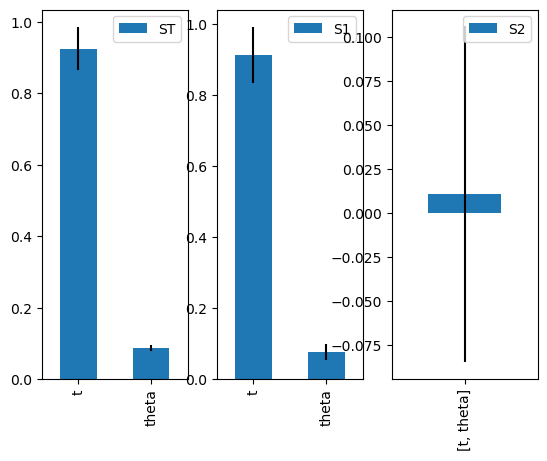

In [38]:
# Turn output to a Pandas DataFrame for further analysis
total_Si, first_Si, second_Si = Si.to_df()
Si.plot()
print(Si.to_df())